In [1]:
#Import packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import openpyxl
from scipy.stats import mannwhitneyu
import seaborn as sns

In [2]:
from functions import *

In [3]:
# Set the directory for the data
results_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/results'
data_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/precuneus_nets'

In [4]:
# Separate the data into 2 groups: (1) aC and (2) nC
xl = pd.ExcelFile('sujetos_time_series_codes.xlsx')
df = xl.parse('datos_demograficos_sanos_schaef')

In [5]:
# Quiero sacar los indices de los sujetos aC y nC
aC_index = df[df['CONDICIÓN']=='aC']
nC_index = df[df['CONDICIÓN']=='nC']

In [6]:
# Directory containing the data
os.chdir(data_dir)

# Load the time series data
ts_data, ts_data_struc, struc_names = process_data(data_dir)

# Select the data for the aC group using the indices
ts_aC_data = ts_data[aC_index.index]

# Select the data for the nC group using the indices
ts_nC_data = ts_data[nC_index.index]

Example plots and data exploration analysis

In [7]:
# Compute the correlation matrices
delta = 66
corr_matrices = split_into_windows_and_compute_correlation(ts_data, delta)
structure_names = struc_names.to_list()


In [8]:
# Access a specific value
subject_id = 'Subject001'
timepoint = 1
structure = 'atlas.Precuneous'

specific_value = ts_data_struc.sel(subject=subject_id, timepoint=timepoint, struc=structure).item()
print(f"The value for {subject_id}, timepoint {timepoint}, structure '{structure}' is {specific_value}.")

The value for Subject001, timepoint 1, structure 'atlas.Precuneous' is -0.0156951029554407.


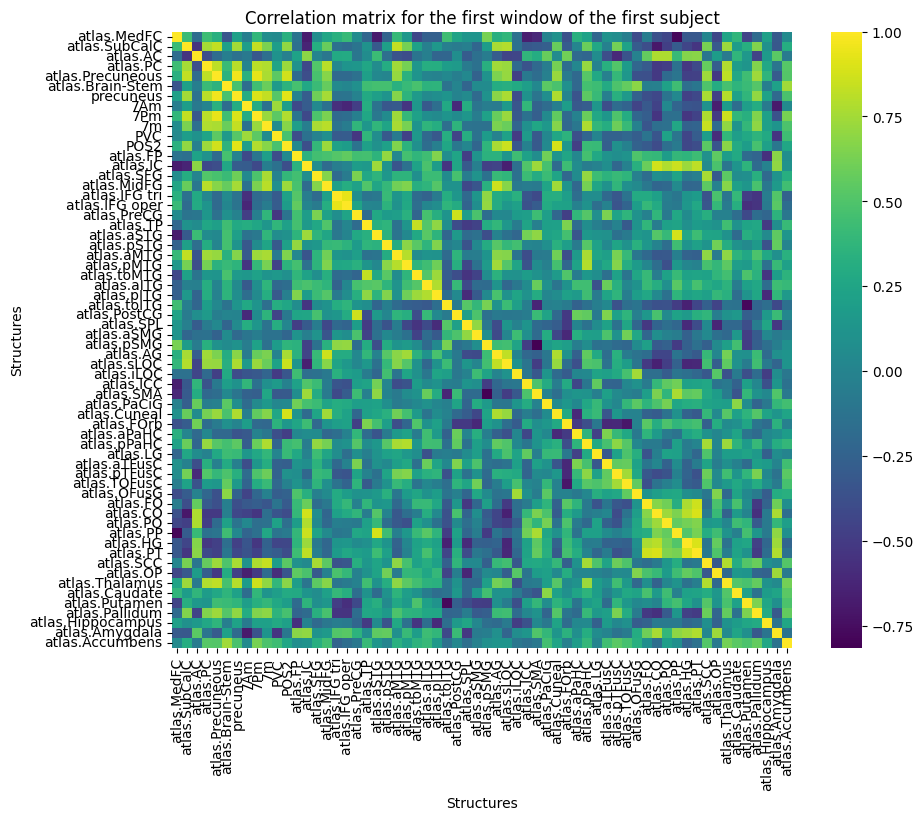

In [9]:
# plot a heatmap (sns) of a correlation matrix (e.g. the first one) from corr_df and add the x and y labels of the structure_names

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrices[:, :, 0, 0], xticklabels=structure_names, yticklabels=structure_names, cmap='viridis')
plt.xlabel('Structures')
plt.ylabel('Structures')
plt.title('Correlation matrix for the first window of the first subject')
plt.show()


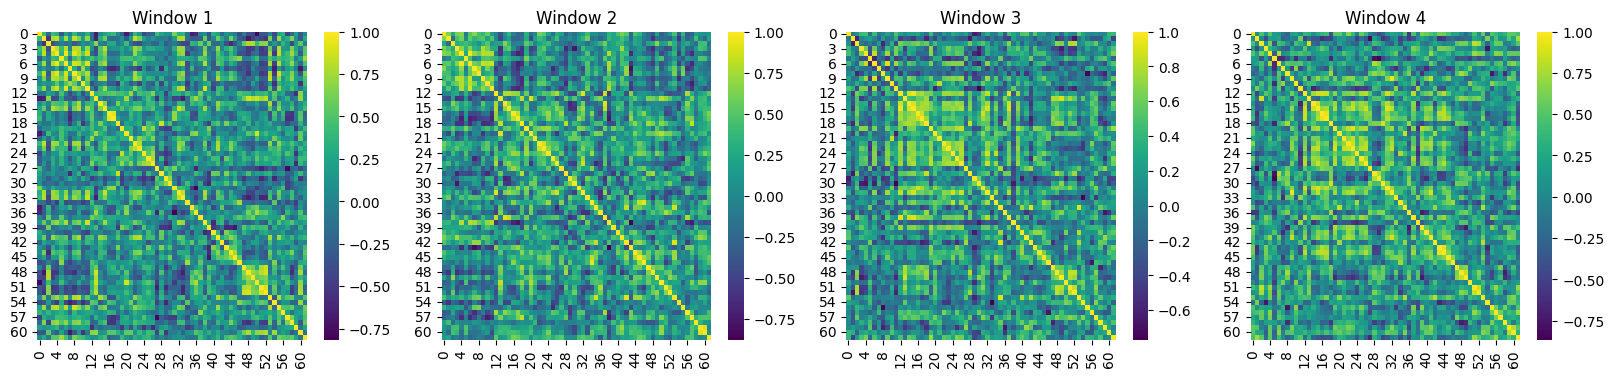

In [10]:
# Make a panel of figures with the correlation matrices for the first subject and all windows (33 windows) a grid of 6x6 figures

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(corr_matrices[:, :, 0, i], cmap='viridis', ax=ax)
    ax.set_title(f'Window {i+1}')

In [11]:
# Access a specific structure
structure = 'atlas.Precuneous'

# Select the data for the specified structure
specific_structure_data = ts_data_struc.sel(struc=structure)
print(f"Data for structure '{structure}':\n", specific_structure_data)

Data for structure 'atlas.Precuneous':
 <xarray.DataArray (subject: 57, timepoint: 264)> Size: 120kB
array([[ 0.01391305, -0.0156951 , -0.03661022, ...,  0.05642792,
        -0.00223421, -0.06272297],
       [ 0.088349  ,  0.02851485, -0.04775371, ..., -0.01664198,
         0.01605906,  0.03971476],
       [-0.04054683, -0.01357598,  0.01996939, ...,  0.08903074,
         0.01164096, -0.08437934],
       ...,
       [-0.09449431, -0.00627745,  0.08604377, ..., -0.00842487,
         0.0106624 ,  0.02360613],
       [-0.03455009, -0.02598357,  0.00797527, ..., -0.00405186,
         0.01776135,  0.01865796],
       [ 0.12555343,  0.00542055, -0.11303777, ..., -0.05880973,
         0.0054838 ,  0.06831283]])
Coordinates:
  * subject    (subject) <U10 2kB 'Subject001' 'Subject002' ... 'Subject057'
  * timepoint  (timepoint) int32 1kB 0 1 2 3 4 5 6 ... 258 259 260 261 262 263
    struc      <U16 64B 'atlas.Precuneous'


INTER-PRECUNEUS ANALYSIS: 6 ANALYSIS IN TOTAL
(1) precuneus (total) with the rest
(2-6) 7Am, 7Pm, 7m, PVC and POS2 with the rest 

In [12]:
# Fix the structure
precuneus_structures = ['precuneus', '7Am', '7Pm', '7m', 'PVC', 'POS2']

# SELECT THE GROUP TO ANALYZE
group_list = ['aC', 'nC']
delta = 66 #number of time points on each window. LB^(-1) = delta * TR (2.2s)

for group in group_list:
    if group == 'aC':
        ts_data = ts_aC_data
    elif group == 'nC':
        ts_data = ts_nC_data

    # Window the data and compute the correlation matrices
    structure_names = struc_names.to_list()
    corr_matrices = split_into_windows_and_compute_correlation(ts_data, delta)
    #print(corr_matrices.shape)  # Debería ser (62, 62, 57, 33)

    for structure in precuneus_structures:
        # We will fix one structure and perfom the analysis
        structure_index = structure_names.index(structure)

        # Seleccionar todas las estructuras excepto la fijada
        remaining_indices = [i for i in range(len(structure_names)) if i != structure_index]

        # Seleccionar los datos correspondientes a la fila de la estructura fijada y las columnas restantes
        corr_matrices_structure_rows = corr_matrices[remaining_indices,:, :, :]
        corr_matrices_structure_col = corr_matrices_structure_rows[:,structure_index, :, :]
        #print(corr_matrices_structure_col[:,2,20]) # Debería ser un vector de 62 elementos. El elemento 6 (precuneus) debería tener valor de corr=1. La correlacion de una estructura consigo misma (6,6) es 1.

        # I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
        # I will have 57 subjects, so the final matrix will be 33x33x57.

        norm_distances = compute_norm_distances(corr_matrices_structure_col)
        print(norm_distances.shape)  # Debería ser (33, 33, 57)

        # Flatten each subject distance matrix to obtain a vector per subject

        flattened_distances = flatten_distance_matrices(norm_distances)
        print(flattened_distances.shape)  # Debería ser (57, 1089)

        # Mean distance per subject
        mean_distances = np.mean(flattened_distances, axis=1)

        # Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
        filename = f'{group}_inter_analysis_mean_distances_{structure}_before_filter.csv'
        np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
        print(f"Mean distances saved to '{filename}'.")

(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_precuneus_before_filter.csv'.
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_7Am_before_filter.csv'.
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_7Pm_before_filter.csv'.
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_7m_before_filter.csv'.
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_PVC_before_filter.csv'.
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_inter_analysis_mean_distances_POS2_before_filter.csv'.
(4, 4, 25)
(25, 16)
Mean distances saved to 'nC_inter_analysis_mean_distances_precuneus_before_filter.csv'.
(4, 4, 25)
(25, 16)
Mean distances saved to 'nC_inter_analysis_mean_distances_7Am_before_filter.csv'.
(4, 4, 25)
(25, 16)
Mean distances saved to 'nC_inter_analysis_mean_distances_7Pm_before_filter.csv'.
(4, 4, 25)
(25, 16)
Mean distances saved to 'nC_inter_analysis_mean_di

INTRA-PRECUNEUS ANALYSIS: 1 IN TOTAL.
7Am, 7Pm, 7m, PCV and POS2 strucs between them

In [13]:
# Fix the 5 structures and find the index of each one
strucs =  '7Am', '7Pm', '7m', 'PVC', 'POS2'

# SELECT THE GROUP TO ANALYZE
group_list = ['aC', 'nC']
delta = 66 #number of time points on each window. LB^(-1) = delta * TR (2.2s)

for group in group_list:
    if group == 'aC':
        ts_data = ts_aC_data
    elif group == 'nC':
        ts_data = ts_nC_data

    # Window the data and compute the correlation matrices
    structure_names = struc_names.to_list()
    corr_matrices = split_into_windows_and_compute_correlation(ts_data, delta)
    #print(corr_matrices.shape)  # Debería ser (62, 62, 57, 33)

    # We will fix one structure and perfom the analysis
    structure_indices = [structure_names.index(s) for s in strucs]

    # Select the data for the specified structure. The final matrix should be 5x5x57x33
    corr_matrices_structure_row = corr_matrices[structure_indices, :, :, :]
    corr_matrices_structure_col = corr_matrices_structure_row[:, structure_indices, :, :]
    print(corr_matrices_structure_col.shape)  # Debe ser: (5,5,57,33)

    # Flatten the intra-structure matrices to compute the norm distance between vectors and no between matrices
    intra_size = corr_matrices_structure_col.shape[0]
    subjects = corr_matrices_structure_col.shape[2]
    windows = corr_matrices_structure_col.shape[3]
    corr_matrices_structure_flat = corr_matrices_structure_col.reshape(intra_size*intra_size, subjects, windows)

    # I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
    # I will have 57 subjects, so the final matrix will be 33x33x57.

    norm_distances = compute_norm_distances(corr_matrices_structure_flat)
    print(norm_distances.shape)  # Debería ser (33, 33, 57)

    # Flatten each subject distance matrix to obtain a vector per subject

    flattened_distances = flatten_distance_matrices(norm_distances)
    print(flattened_distances.shape)  # Debería ser (57, 1089)

    # Mean distance per subject
    mean_distances = np.mean(flattened_distances, axis=1)

    # Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
    filename = f'{group}_intra_analysis_mean_distances_5precuneus_before_filter.csv'
    np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
    print(f"Mean distances saved to '{filename}'.")

(5, 5, 32, 4)
(4, 4, 32)
(32, 16)
Mean distances saved to 'aC_intra_analysis_mean_distances_5precuneus_before_filter.csv'.
(5, 5, 25, 4)
(4, 4, 25)
(25, 16)
Mean distances saved to 'nC_intra_analysis_mean_distances_5precuneus_before_filter.csv'.


Non-parametric t-test between groups (aC vs. nC): 7 comparisons. (1) intra-5precuneus (6) inter-precuneus, 7Am, 7Pm, 7m, PVC, POS2

RESULTS COMPARISON

In [14]:
# Directory containing the CSV files
results_dir = "C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/results/before_filter"

# Initialize lists to store filenames
aC_files = []
nC_files = []

# Separate filenames into aC and nC lists
for filename in os.listdir(results_dir):
    if filename.startswith("aC"):
        aC_files.append(filename)
    elif filename.startswith("nC"):
        nC_files.append(filename)

# Extract structure names without prefixes and suffixes for matching
aC_structures = [filename.split('_')[5].split('.')[0] for filename in aC_files]
nC_structures = [filename.split('_')[5].split('.')[0] for filename in nC_files]

# Initialize lists to store results
results = []

# Perform Mann-Whitney U test for 5precuneus (intra-analysis)
ac_file = "aC_intra_analysis_mean_distances_5precuneus_before_filter.csv"
nc_file = "nC_intra_analysis_mean_distances_5precuneus_before_filter.csv"
ac_data = pd.read_csv(os.path.join(results_dir, ac_file))
nc_data = pd.read_csv(os.path.join(results_dir, nc_file))

ac_values = ac_data.iloc[:, 0]
nc_values = nc_data.iloc[:, 0]

stat, p_value = mannwhitneyu(ac_values, nc_values, alternative='two-sided')

results.append({'Structure': '5precuneus', 'U-statistic': stat, 'p-value': p_value, 'Comparison': 'Intra'})

# Perform Mann-Whitney U test for each matching structure (inter-analysis)
for structure in set(aC_structures) & set(nC_structures):
    if structure == '5precuneus':
        continue
    
    aC_file = next(f for f in aC_files if structure in f)
    nC_file = next(f for f in nC_files if structure in f)
    
    # Load data for the current structure
    aC_data = pd.read_csv(os.path.join(results_dir, aC_file))
    nC_data = pd.read_csv(os.path.join(results_dir, nC_file))

    # Assuming the data is in a single column, if there are multiple columns, specify the correct one
    aC_values = aC_data.iloc[:, 0]
    nC_values = nC_data.iloc[:, 0]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(aC_values, nC_values, alternative='two-sided')

    # Append results
    results.append({'Structure': structure, 'U-statistic': stat, 'p-value': p_value, 'Comparison': 'Inter'})

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Apply Bonferroni correction
num_comparisons = len(results_df)
bonferroni_alpha = 0.05 / num_comparisons

# Determine if the corrected p-value is significant
results_df['significant'] = results_df['p-value'] < bonferroni_alpha

print('Bonferroni alpha: 0.05/num.comparisons =', bonferroni_alpha)
print(results_df)


Bonferroni alpha: 0.05/num.comparisons = 0.0071428571428571435
    Structure  U-statistic   p-value Comparison  significant
0  5precuneus        322.0  0.400869      Intra        False
1         7Am        294.0  0.188422      Inter        False
2        POS2        354.0  0.766471      Inter        False
3         PVC        369.0  0.966158      Inter        False
4          7m        481.0  0.065568      Inter        False
5   precuneus        424.0  0.382112      Inter        False
6         7Pm        274.0  0.097989      Inter        False


Results plotting: Probability density of mean distances for both groups

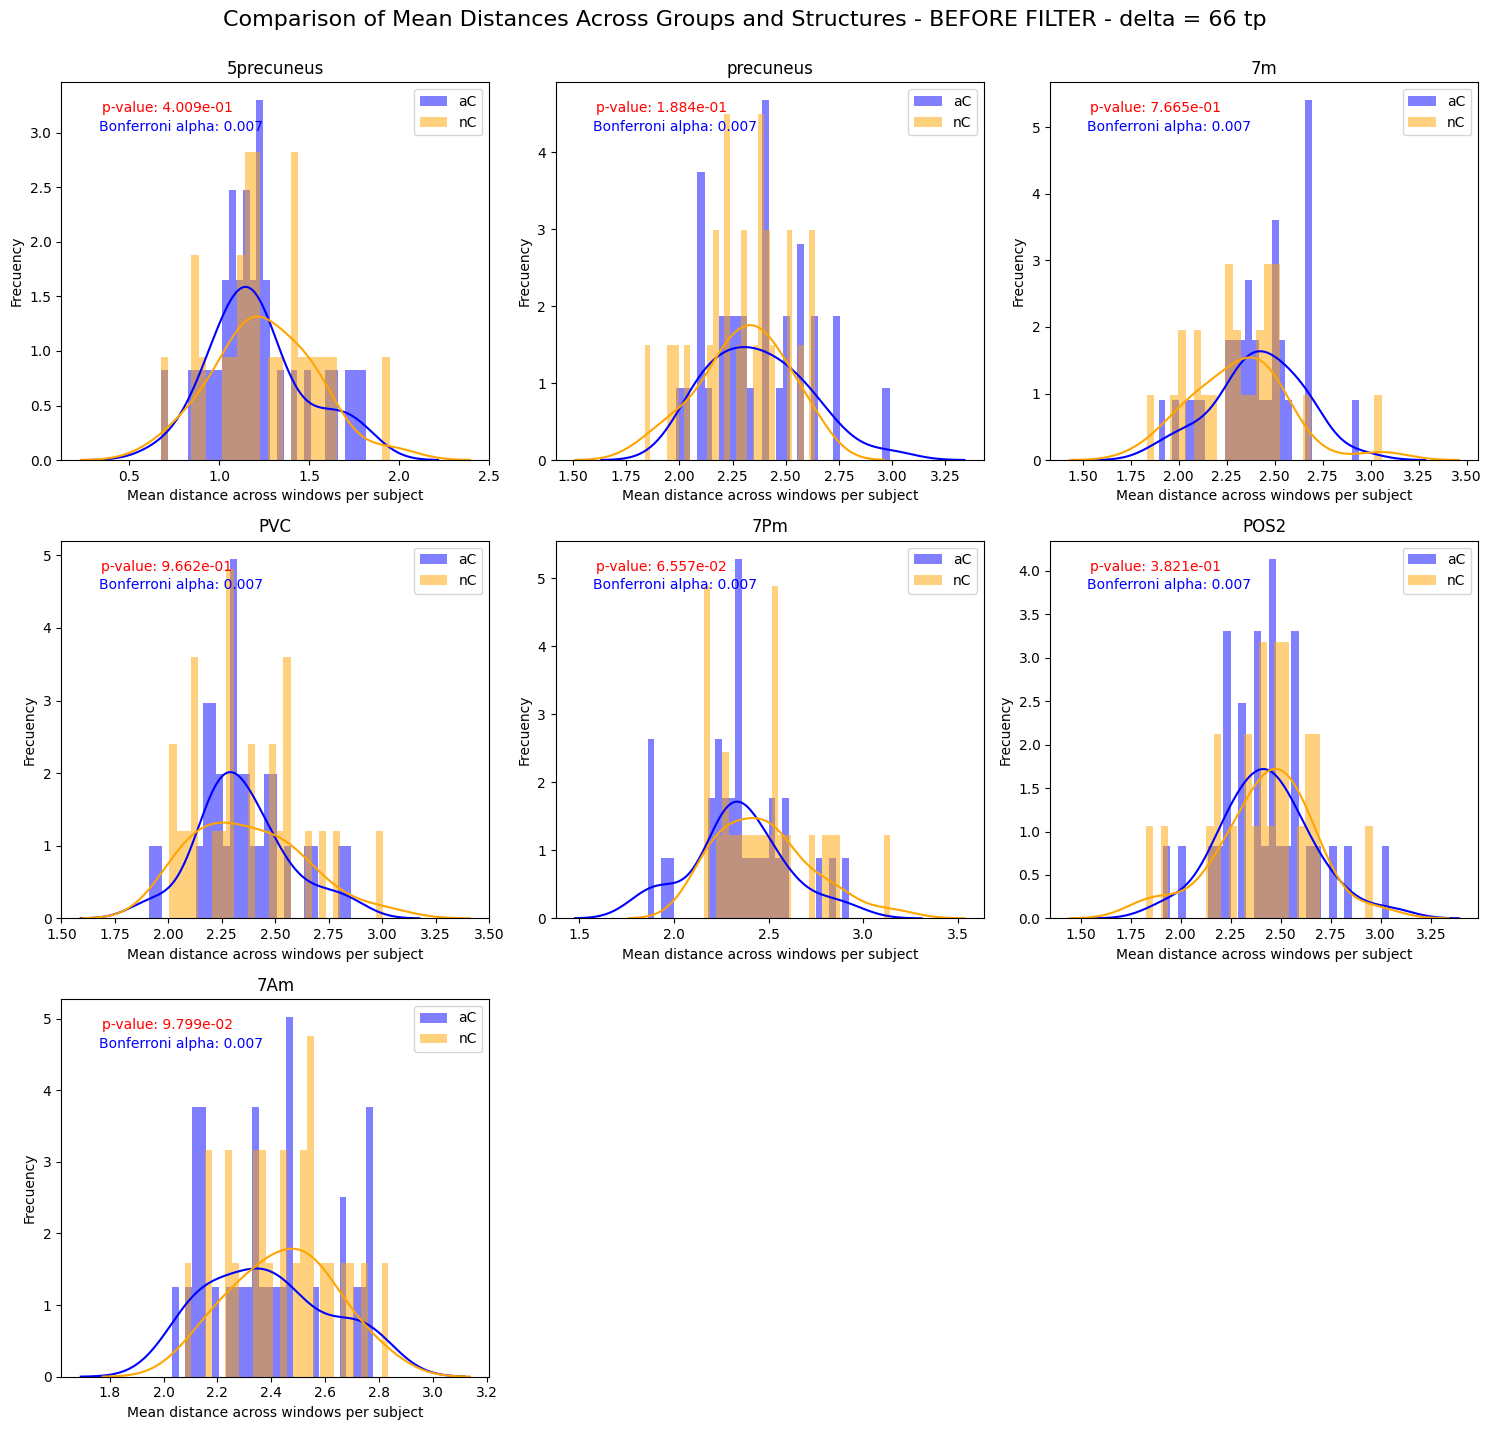

In [16]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

results_dir = "C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/results/before_filter"

# Listas de grupos y estructuras
group_list = ['aC', 'nC']
strucs = ['5precuneus', 'precuneus', '7m', 'PVC','7Pm','POS2' ,'7Am' ]
group_colors = {'aC': 'blue', 'nC': 'orange'}  # Define los colores para cada grupo


# Crear una figura y ejes para un panel de 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Bucle sobre cada estructura
for idx, structure in enumerate(strucs):
    ax = axes[idx]
    for group in group_list:
        color = group_colors[group]
        if structure == '5precuneus':
            filename = f'{group}_intra_analysis_mean_distances_{structure}_before_filter.csv'
        else:
            filename = f'{group}_inter_analysis_mean_distances_{structure}_before_filter.csv'
        
        filepath = os.path.join(results_dir,filename)
        
        try:
            data = np.loadtxt(filepath, delimiter=',')
            # Histograma
            ax.hist(data, bins=30, density=True, alpha=0.5, label=group, color=color)
            # KDE Plot
            sns.kdeplot(data, ax=ax, color=color)
        except FileNotFoundError:
            print(f"File not found: {filepath}")
    
    # Extract the p-value for the current structure from the DataFrame
    p_value = results_df.iloc[idx, 2]

    ax.set_title(f'{structure}')
    ax.set_xlabel('Mean distance across windows per subject')
    ax.set_ylabel('Frecuency')
    ax.legend()

    # Add p-value text to the plot
    ax.text(0.4, 0.95, f'p-value: {p_value:.3e}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, color='red', fontsize=10)
    
    # Add corrected p-value text to the plot
    ax.text(0.47, 0.90, f'Bonferroni alpha: {bonferroni_alpha:.3f}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, color='blue', fontsize=10)
    
# Eliminar ejes vacíos si hay menos de 9 estructuras
for i in range(len(strucs), 9):
    fig.delaxes(axes[i])

fig.suptitle('Comparison of Mean Distances Across Groups and Structures - BEFORE FILTER - delta = 66 tp', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to accommodate the suptitle
plt.show()